In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, converge_ZNE_order, converge_ZNE_loocv

from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from samplers_util import thermal_rejection
from functions_util import calibrate_sim_Omegas


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0, 0.5, 'Polarized Population')

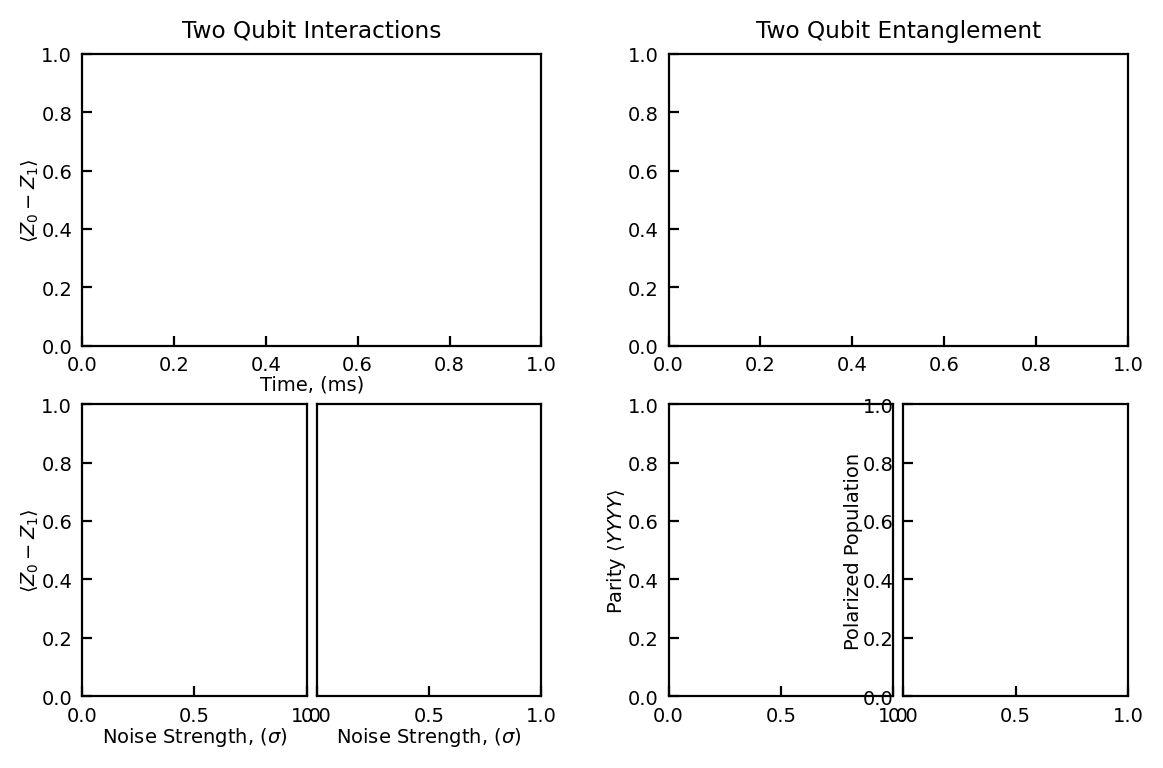

In [2]:
"""Figure includes Rabi oscillations for Gaussian noise, and regions for Rydberg and trapped ion error mechanisms. 
|---|--|
|   |  |
|-|-|--|
| | |  |
|-|-|--|
"""

#Create a matplotlib subplots in the layout above
import matplotlib as mpl
scol=(3+3/8) #single column width of PRL,
dcol=2*scol # double column,
fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": False,
    "figure.dpi":200,
    "figure.figsize": [2*scol, 2*scol * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(2, 18)  # 2x2 grid
ax_a = fig.add_subplot(gs[0, :8])  # First row, first column
ax_bi = fig.add_subplot(gs[1, :4])  # First row, second column
ax_bii = fig.add_subplot(gs[1, 4:8])  # First row, second column

ax_c = fig.add_subplot(gs[0, 10:])  # First row, second column
ax_di = fig.add_subplot(gs[1, 10:14])  # First row, second column
ax_dii = fig.add_subplot(gs[1, 14:])  # First row, second

#ax_a = fig.add_subplot(221)
#ax_bi = fig.add_subplot(245)
#ax_bii = fig.add_subplot(246)
#ax_c = fig.add_subplot(222)
#ax_di = fig.add_subplot(247)
#ax_dii = fig.add_subplot(248)



ax_bii.yaxis.tick_right()


ax_a.set_xlabel(r'Time, ($\mathrm{ms}$)', usetex=1)
ax_a.set_title('Two Qubit Interactions')
ax_a.set_ylabel(r'$\langle Z_0 -Z_1 \rangle$')
#Axis b (i)


ax_bi.set_xlabel(r'Noise Strength, ($\sigma$)')
ax_bii.set_xlabel(r'Noise Strength, ($\sigma$)')
ax_bi.set_ylabel(r'$\langle Z_0 -Z_1 \rangle$')
ax_bii.set_yticks([])

ax_c.set_title('Two Qubit Entanglement')
ax_di.set_ylabel(r'Parity $\langle YYYY \rangle$')
ax_dii.set_ylabel(r'Polarized Population')

#fig.tight_layout()
#plt.show()


In [3]:
file = np.load('plotting_data_fig_4.npz')
#np.savez('Plotting data', times = times, leakage_matrix = leakage_matrix, flopping_matrix = flopping_matrix, flopping_std_matrix = flopping_std_matrix, flopping_matrix_ps = flopping_matrix_ps, flopping_matrix_smooth = flopping_matrix_smooth, flopping_std_matrix_smooth = flopping_std_matrix_smooth, ZNE_data = ZNE_data, ZNE_data_smooth = ZNE_data_smooth, Omega = Omega, decoherence_limit = decoherence_limit)
times = file['times']
theta_list = file['theta_list']
flopping_ps_smoothed = file['flopping_ps_smoothed']
flopping_std_matrix = file['flopping_std_matrix']
shots = file['shots']
Omega = file['Omega']
flopping_matrix_smooth = file['flopping_matrix_smooth']
flopping_matrix = file['flopping_matrix']
leakage_matrix = file['leakage_matrix']
#import all data:



theta_sub_index = [0, 1, 2, 3, 4]#, 5,6,]
#theta_sub_index = [i for i in range(len(theta_list))]
theta_sub_index_mask = [i in theta_sub_index for i in range(len(theta_list))]
weights_comp = np.array([1, 1, 1, 1, 1.5, 2,4])
weights_comp = np.ones(len(theta_sub_index))
#Make font size 16

ZNE_function = converge_ZNE_loocv
ZNE_function = lambda x, y, weights: converge_ZNE_loocv(x, y, debug=False, weights=weights)

cmap = LinearSegmentedColormap.from_list("mycmap", ["blue", "red"])
for index in range(len(theta_sub_index)):
    name_index = theta_sub_index[index]
    color = cmap(index/len(theta_sub_index))
    #plt.plot(times, 1-leakage_matrix[:,name_index], label = data_names[name_index], color = color)
    #plt.plot(times, flopping_matrix_fit[:,name_index], label = data_names[name_index], color = color)
    ax_a.errorbar(times, flopping_ps_smoothed[:,name_index],  yerr = flopping_std_matrix[:,name_index]/np.sqrt(shots), color = color)
    #plt.plot(times, -1+leakage_matrix[:,name_index], label = data_names[name_index], color = color)

#Get ZNed Data:
ZNE_data_ps = np.zeros(len(times))
ZNE_data_raw = np.zeros(len(times))
ZNE_funcs = []
ZNE_funcs_ps = []
for i in range(30):
    #fit_func = third_no_first_ZNE(theta_list[theta_sub_index_mask], flopping_matrix[i,theta_sub_index_mask])
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_ps_smoothed[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs_ps.append(fit_func)
    ZNE_data_ps[i] = fit_func(0)
    fit_func = ZNE_function(theta_list[theta_sub_index_mask], flopping_matrix_smooth[i,theta_sub_index_mask], weights=flopping_std_matrix[i,theta_sub_index_mask]/np.sqrt(shots)*weights_comp)
    ZNE_funcs.append(fit_func)
    ZNE_data_raw[i] = fit_func(0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(theta_list), vmax=max(theta_list[theta_sub_index_mask])))
#sm.set_label(r'Temperature ($\lambda$)')
#Add the color bar to the plot:
cbar = plt.colorbar(sm, ax=ax_a)
cbar.set_label(r'Temperature: $\theta$')

ax_a.plot(times, np.cos(Omega[0]*times), label = 'Ideal Oscillations', color = 'g', linestyle='--')
ZNE_data_smooth_ps = savgol_filter(ZNE_data_ps, 6, 2)
ZNE_data_smooth = savgol_filter(ZNE_data_raw, 6, 2)

ax_a.plot(times, ZNE_data_smooth, label = 'ZNE', color = 'k')
ax_a.set_title('Experimental Bell State Oscillations')
ax_a.set_ylabel('Expectation Value <Z_0> - <Z_1>')
ax_a.set_xlabel('Time (ms)')
ax_a.set_ylim(-1.1,1.1)
#ax.plot(times, ZNE_data, label = 'ZNE', color = 'k', linestyle='--')
ax_a.legend(ncol=2)

dense_theta = np.linspace(0, theta_list[theta_sub_index[-1]]+0.02, 25)


Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed
Loocv failed


<Figure size 1350x834.346 with 0 Axes>

In [4]:
#Generate dense theta simulation data:  from detune scanning




#Simulating the Jij XX oscillations with active heating + maybe dephasing noise
"""How to deal with active heating of the chain?
Option 1: increase the random theta linearly in time. Probably the best bet. 
Option 2: rescample ever few time steps with a higher temperature.

I think option 1 is the best for now
"""
#Need to set Jij ~1000*2*pi, so Omega = np.sqrt(1000). This way the time scale is ms for a full Jij oscillation
#Realistic:
#theta_0  = 0.060577043438396795
#theta_dot = 0.0502438865537055 * 1e3
#print(theta_0)
#print(theta_dot)
#Not realistic:
theta_0  = 0.055577043438396795
#theta_0 = 0
theta_dot = 0.02172438865537055 * 1e3
#theta_0 = 0
#theta_dot = 0
sx, sy, sz = get_s_lists(2)

#t_list = np.linspace(0, max(times), 200)# * 1e-3
t_list = times
psi0 = tensor(basis(2,0), basis(2,1))


def J_func(J,i,j):
    return J*np.exp(-1*abs(i-j)+1)

def genH(theta_0, J, B):
    delta = thermal_rejection(theta_0,1)[0]
    factor = (1 - delta)**2
    #HXX = sx[0]*0
    #for i in range(2):
    #    for j in range(i+1,2):
    #        HXX += J_func(J,i,j)*factor*(sx[i]*sx[j])
    HXX = J*sx[0]*sx[1]*factor
    
    #HXX = sum([ sum( [J(i,j)*factor*(sx[i]*sx[j]) of i in range(j+1,4)] for j in range(4)]))

    #HXX = J*factor*(sx[0]*sx[1]) 
    #print(HXX)
    HB = B*(sz[0] + sz[1])# + sz[2] + sz[3])
    #print(HB)

    return [HXX + HB]


#psi0 = tensor(basis(2,0), basis(2,0))
#yplus = (basis(2,0) + 1j*basis(2,1)).unit()
#minus = 
#psi0 = tensor(yplus, yplus)

#import Options from qutip:
from qutip.solver import Options
#increase nsteps
options = Options(nsteps=1e3)

def run(J,B, obs = None, noise={}, time = t_list):
    xrate = 0
    zrate = 0
    theta_0 = 0
    try:
        xrate = noise['x']
    except:
        pass
    try:
        zrate = noise['z']
    except:
        pass
    try:
        theta_0 = noise['theta']
    except:
        pass
    #print(xrate)
    #print(zrate)
    #print(theta_0)
    H = genH(theta_0,J,B)
    noisy_ops = [sx[i]*xrate for i in range(2)]
    noisy_ops = [sx[0]*xrate]
    #Sz_noise = (sz[0] * sz[1])*zrate#*sx[2]*sz[3])*zrate
    Sz_noise = [sz[i]*zrate for i in range(2)]
    #noisy_ops = []
    noisy_ops.append(Sz_noise)
    
    results = mesolve(H, psi0,time, noisy_ops, obs, options=options)#, ntraj=1)
    return results
sim_shots = 500
#


#full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, theta_dot,Omega) for i in range(shots))
    

def gen_full_results(J,B, obs=None, noise={}, time=t_list):
    #H = genH(theta_0, theta_dot)
    #run(theta_0, J,B)
    #print(noise)
    #full_results = Parallel(n_jobs=6)(delayed(run)(theta_0, J,B,obs = obs, noise=noise, time=time) for _ in range(shots))
    full_results = np.array([run(J,B,obs = obs, noise=noise, time=time) for _ in range(sim_shots)])
    
    averaged = np.zeros(len(time))
    for item in full_results:
        #print(item.expect[0])
        averaged += sum(item.expect)
    averaged = averaged/sim_shots
    return averaged#[indices]
#fit leakage matrix to a line:
def linear(x, m, c):
    return m*x + c
popt, pcov = curve_fit(linear, times, leakage_matrix[:,0])
print(popt)
intercept = 1-popt[1]
slope = popt[0]

[0.06176561 0.19503943]


In [5]:
J = 1.05*np.pi#*0.95/2
B = 0#0.4*J
leakage_obs = [sz[0]*sz[1]]#
oscillation_obs = [sz[0], -1*sz[1]]
#print(np.sqrt(0.0015)*J)
noise_dict = {'x':np.sqrt(slope), 'z':0, 'theta':0.065}

results_Jij_oscillation = gen_full_results(J, B, obs=oscillation_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
results_Jij_leakage = gen_full_results( J, B, obs=leakage_obs, noise=noise_dict)#, noise={'x':xrate, 'z':zrate, 'theta':theta_0})
#Check if dense_theta_oscillations is defined. If not, define it

Omega_comps = calibrate_sim_Omegas(dense_theta, np.sqrt(J), times, debug=False)*np.sqrt(J)
J_calibrated = Omega_comps**2

try:
    dense_theta_oscillations
except:
    dense_theta_oscillations = []
    for theta_index in range(len(dense_theta)):
        theta = dense_theta[theta_index]
        J_calibrated = Omega_comps[theta_index]**2
        
    #for theta_point in dense_theta:
        noise_dict['theta'] = theta#{'x':np.sqrt(slope), 'z':0, 'theta':theta_point}
        dense_theta_oscillations.append(gen_full_results(J_calibrated, B, obs=oscillation_obs, noise=noise_dict))
        

/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [6]:
# plt.plot(times, results_Jij_oscillation*intercept/2, label = 'sim', color = 'r')
# plt.plot(times, flopping_matrix[:,0])
# plt.plot(times, flopping_matrix_smooth[:,0])
# #plt.plot(times, flopping_ps_smoothed[:,0])
# plt.legend()

In [7]:
# plt.plot(times, 1+results_Jij_leakage*intercept, label = 'Leakage', color = 'r')
# plt.plot(times, leakage_matrix[:,0], label = 'Experimental Leakage', color = 'k')

In [8]:
#Plotting the ZNE Data slice:
#Add a vertial slice at the 3rd peak:
index = 12
dense_theta_oscillations_array = np.array(dense_theta_oscillations)

ax_a.axvline(x=times[index], color='orange', linestyle='--')
ax_a.plot(times, intercept/2*dense_theta_oscillations_array[0,:], label = 'Simulated', color = 'b')
#Plot the error axis at the slice:
ax_bi.errorbar(theta_list[theta_sub_index_mask], flopping_matrix_smooth[index,theta_sub_index_mask], label = 'Experimental Data', color = 'k', yerr=flopping_std_matrix[index,theta_sub_index_mask]/np.sqrt(shots), fmt='o')
ax_bi.set_xlim(0, theta_list[theta_sub_index[-1]]+0.02)
dense_flopping = ZNE_funcs_ps[index](dense_theta)
dense_ZNE_no_ps = ZNE_funcs[index](dense_theta)
ax_bi.plot(dense_theta, dense_ZNE_no_ps, label = 'Fit', color = 'r')
ax_bi.errorbar(dense_theta, dense_theta_oscillations_array[:,index]/2*intercept, label = 'Simulated', color = 'b', yerr=1/np.sqrt(sim_shots), capsize=3, zorder=-1)
ax_bi.set_title('ZNE at Orange time slice')

Text(0.5, 1.0, 'ZNE at Orange time slice')

In [9]:
errors_basic = np.abs((np.cos(Omega[0]*times) - flopping_matrix[:,0])/np.cos(Omega[0]*times))
errors_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth)/np.cos(Omega[0]*times))
errors_PS_ZNE = np.abs((np.cos(Omega[0]*times) - ZNE_data_smooth_ps)/np.cos(Omega[0]*times))
errors_PS_only = np.abs((np.cos(Omega[0]*times) - flopping_ps_smoothed[:,0])/np.cos(Omega[0]*times))
#Smooth all the errors by convolving with a gaussian:
window = 10
#errors_basic = savgol_filter(errors_basic, window, 1)
#errors_ZNE = savgol_filter(errors_ZNE, window, 1)
#errors_PS_ZNE = savgol_filter(errors_PS_ZNE, window, 1)
#errors_PS_only = savgol_filter(errors_PS_only, window, 1)

ax_bii.plot(times, errors_basic, label = 'Basic', color = 'k')
ax_bii.plot(times, errors_PS_only, label = 'PS', color = 'g')
ax_bii.plot(times, errors_ZNE, label = 'ZNE', color = 'r')
ax_bii.plot(times, errors_PS_ZNE, label = 'ZNE + PS', color = 'b')
ax_bii.set_yscale('log')
ax_bii.set_title('Averaged Error')

ax_bii.legend()

In [10]:
#plt.show()
print(fig)
fig.tight_layout(pad=0)
fig.savefig('Figure_4.png', dpi=600)
fig.savefig('Figure_4.svg', dpi=600)
fig.savefig('Figure_4.pdf', dpi=600)



Figure(1350x834.346)


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_31422/841831580.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=0)
